# Basic training and prediction with CNNs

Convolutional Neural Networks (CNNs) are a popular tool for developing automated machine learning classifiers on images or image-like samples. By converting audio into a two-dimensional frequency vs. time representation such as a spectrogram, we can generate image-like samples that can be used to train CNNs. This tutorial demonstrates the basic use of OpenSoundscape's `preprocessors` and `cnn` modules for training CNNs and making predictions using CNNs.

Under the hood, OpenSoundscape uses Pytorch for machine learning tasks. By using OpenSoundscape's CNN classes such as `Resnet18Multiclass` in combination with preprocessor classes such as `CNNPreprocessor`, you can train and predict with PyTorch's powerful CNN architectures. 

First, let's import some utilities.

In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor

# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import Resnet18Multiclass, Resnet18Binary

#other utilities and packages
from opensoundscape.helpers import run_command
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

Set manual seeds for pytorch and python. These ensure the training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [2]:
torch.manual_seed(0)
random.seed(0)

## Prepare audio data

### Download labeled audio files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's Raven sound analysis software.

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [3]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

### Generate one-hot encoded labels 

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

In [4]:
#load Specky output: a table of labeled audio files
specky_table = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
specky_table.head()

,filename,woodcock,sound_type
0,d4c40b6066b489518f8da83af1ee4984.wav,present,song
1,e84a4b60a4f2d049d73162ee99a7ead8.wav,absent,na
2,79678c979ebb880d5ed6d56f26ba69ff.wav,present,song
3,49890077267b569e142440fa39b3041c.wav,present,song
4,0c453a87185d8c7ce05c5c5ac5d525dc.wav,present,song


This table must provide an accurate path to the files of interest. For this self-contained tutorial, we can use relative paths (starting with a dot and referring to files in the same folder), but you may want to use absolute paths for your training.

In [5]:
#update the paths to the audio files
specky_table.filename = ['./woodcock_labeled_data/'+f for f in specky_table.filename]
specky_table.head()

,filename,woodcock,sound_type
0,./woodcock_labeled_data/d4c40b6066b489518f8da8...,present,song
1,./woodcock_labeled_data/e84a4b60a4f2d049d73162...,absent,na
2,./woodcock_labeled_data/79678c979ebb880d5ed6d5...,present,song
3,./woodcock_labeled_data/49890077267b569e142440...,present,song
4,./woodcock_labeled_data/0c453a87185d8c7ce05c5c...,present,song


We then use the `categorical_to_one_hot` function from `opensoundscape.annotations` to crate "one hot" labels - that is, a column for every class, with 1 for present or 0 for absent in each sample's row. In this case, our classes are simply `'negative'` for files without a woodcock and `'positive'` for files with a woodcock. 

We'll need to put the paths to audio files as the index of the DataFrame.

Note that these classes are mutually exclusive, so we have a "single-target" problem, as opposed to a "multi-target" problem where multiple classes can simultaneously be present. 

In [6]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(specky_table[['woodcock']].values)
labels = pd.DataFrame(index=specky_table['filename'],data=one_hot_labels,columns=classes)
labels.head()

,absent,present
filename,,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0,1
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1,0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0,1
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1


If we want to, we can always convert one_hot labels back to categorical labels:

In [7]:
from opensoundscape.annotations import one_hot_to_categorical
categorical_labels = one_hot_to_categorical(one_hot_labels,classes)
categorical_labels[:3]

[['present'], ['absent'], ['present']]

### Split into training and validation sets
We use a utility from `sklearn` to randomly divide the labeled samples into two sets. The first set, `train_df`, will be used to train the CNN, while the second set, `valid_df`, will be used to test how well the model can predict the classes of samples that it was not trained with.

During the training process, the CNN will go through all of the samples once every "epoch" for several (sometimes hundreds of) epochs. Each epoch usually consists of a "learning" step and a "validation" step. In the learning step, the CNN iterates through all of the training samples while the computer program is modifying the weights of the convolutional neural network. In the validation step, the program performs prediction on all of the validation samples and prints out metrics to assess how well the classifier generalizes to unseen data.

In [8]:
from sklearn.model_selection import train_test_split
train_df,valid_df = train_test_split(labels,test_size=0.2,random_state=1)

### Create preprocessors for training and validation
Preprocessors in OpenSoundscape can be used to process audio data, especially for training and prediction with convolutional neural networks.

To train a CNN, we use `CnnPreprocessor`, which loads audio files, creates spectrograms, performs various augmentations to the spectrograms, and returns a pytorch Tensor to be used in training or prediction. All of the steps in the preprocessing pipeline can be modified or skipped by modifying the preprocessor's `.actions`. For details on how to modify and customize a preprocessor, see the `preprocessing` notebook/tutorial. 

Each Preprocessor must be initialized with a very specific dataframe with the following attributes:

- the index of the dataframe provides paths to audio samples
- the columns are the class names
- the values are 0 (absent/False) or 1 (present/True) for each sample and each class.

The `train_df` and `valid_df` we created above meet these needs:

In [9]:
train_df.head()

,absent,present
filename,,
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1
./woodcock_labeled_data/ad90eefb6196ca83f9cf43b6f56c4b4a.wav,0,1
./woodcock_labeled_data/e9e7153d11de3ac8fc3f7164d43bac92.wav,0,1
./woodcock_labeled_data/c057a4486b25cd638850fc07399385b2.wav,0,1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1


We next create separate preprocessors for training and for validation. These data will be assessed separately each epoch, as described above.

In [10]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df)

valid_dataset = CnnPreprocessor(valid_df)

### Inspect training images
Before creating a machine learning algorithm, we strongly recommend making sure the images coming out of the preprocessor look like you expect them to. Here we generate images for a few samples.

First, in order to view the images, we need a helper function that correctly displays the Tensor that comes out of the Preprocessor.

In [11]:
# helper function for displaying a sample as an image 
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

Now, load a handful of random samples, printing the labels and image for each:

labels: tensor([0, 1])


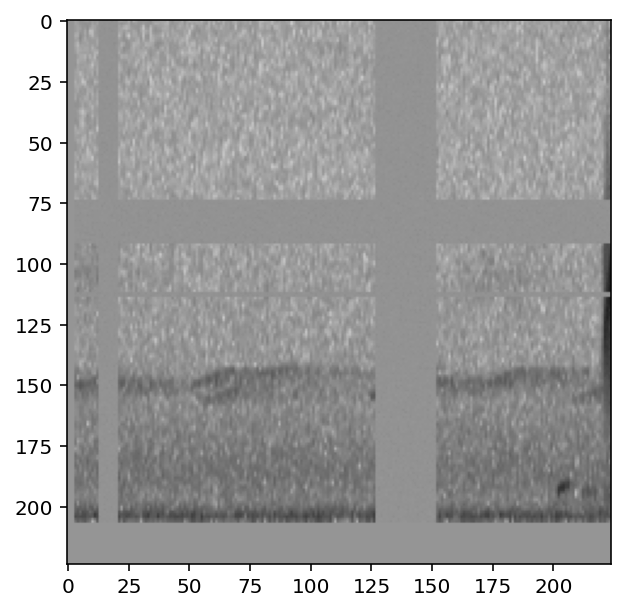

labels: tensor([1, 0])


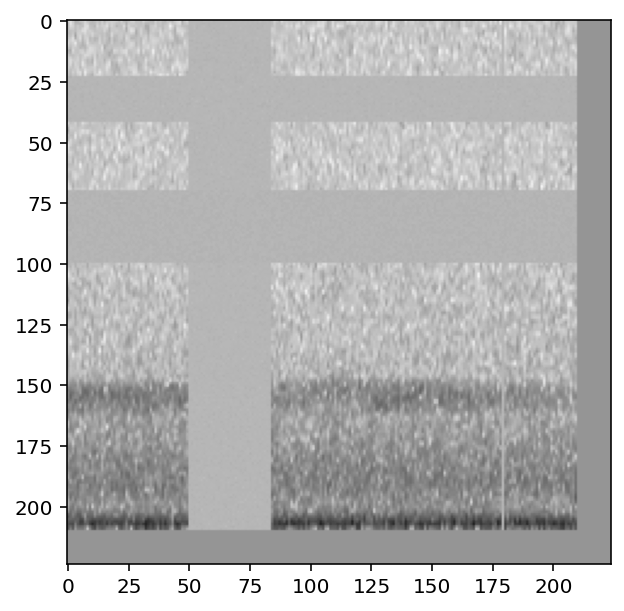

labels: tensor([0, 1])


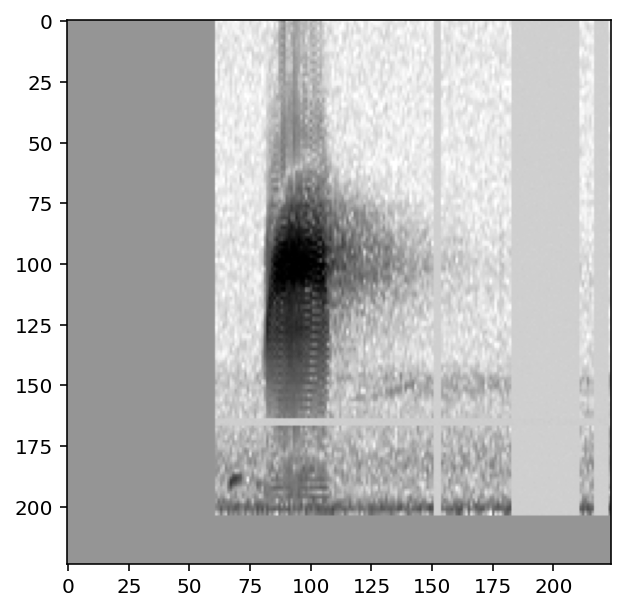

labels: tensor([0, 1])


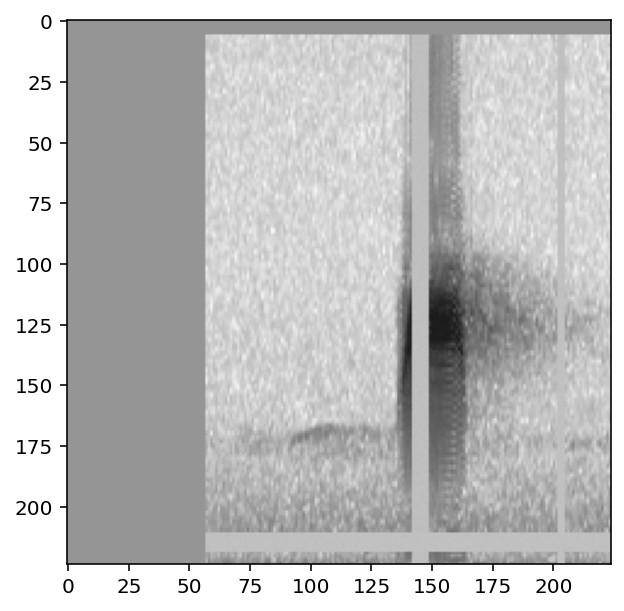

In [12]:
for i, d in enumerate(train_dataset.sample(n=4)):
    print(f"labels: {d['y']}")
    show_tensor(d)

The `CnnPreprocessor` preprocessor allows you to turn all augmentation off or on as desired. Inspect the unaugmented images as well:

labels: tensor([0, 1])


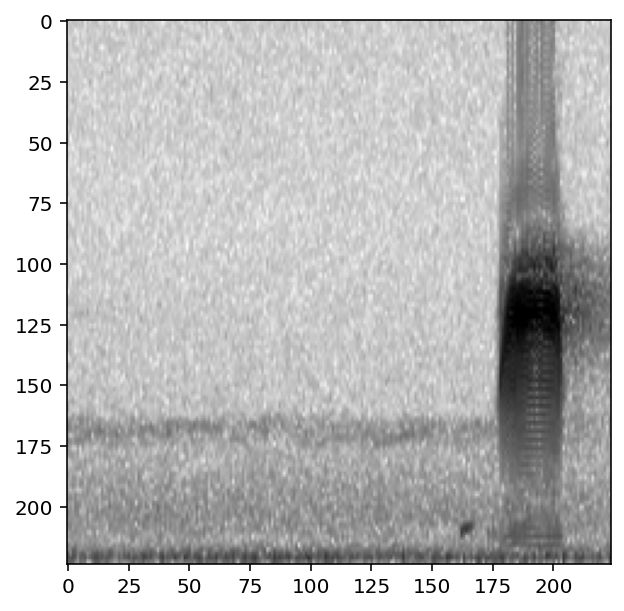

labels: tensor([0, 1])


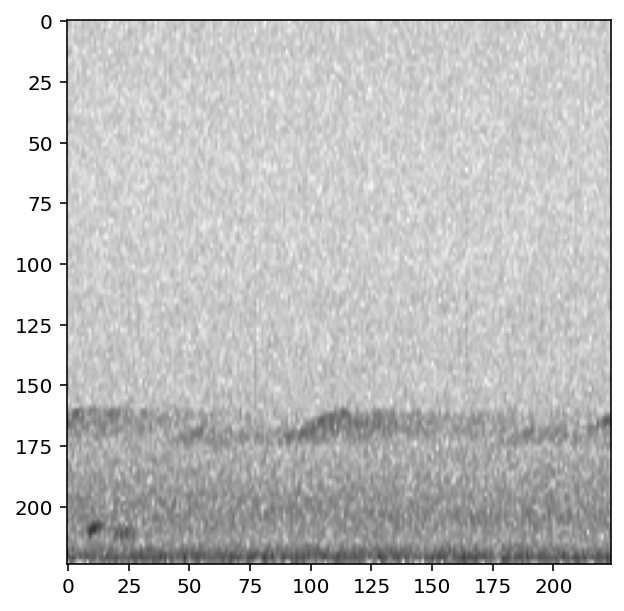

labels: tensor([0, 1])


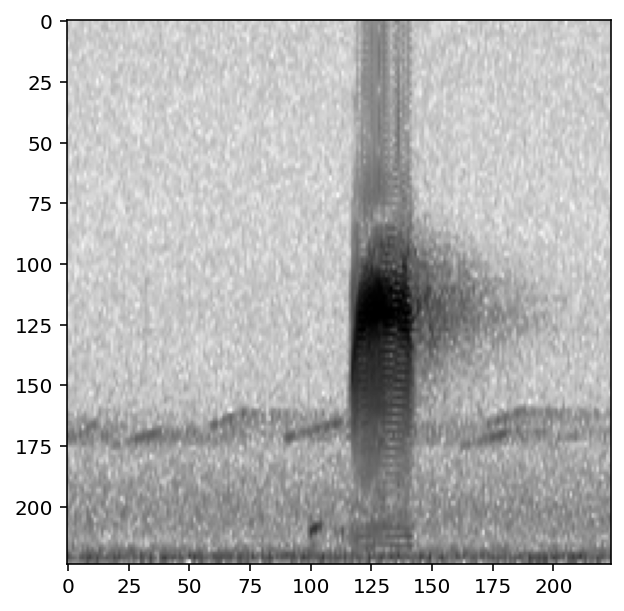

labels: tensor([1, 0])


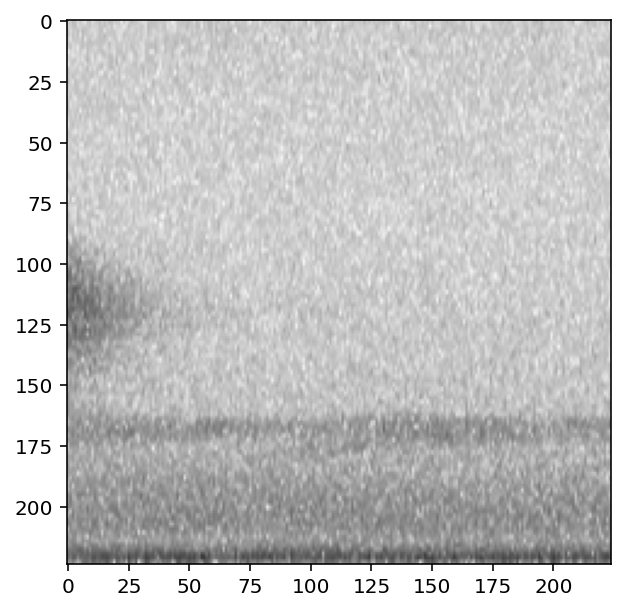

In [13]:
train_dataset.augmentation_off()
for i, d in enumerate(train_dataset.sample(n=4)):
    print(f"labels: {d['y']}")
    show_tensor(d)

## Training
Now, we create a convolutional neural network model object, train it on the `train_dataset` with validation from `valid_dataset`, and use it for prediction. 

### Set up a two-class, single-target model
This demonstrates using a two class, single-target model. 

* The two classes in this case are "positive" and "negative." 
* The model is "single target," meaning that each sample belongs to exactly one class, "positive" or "negative" 

We usually use two-class, single-target models to predict the presence or absence of a single species. We often refer to this as a "binary" model, but be careful not to confuse this for a thresholded model with binarized (1/0) outputs.

The model object should be initialized with a list of class names that matches the class names in the training dataset. We use the Resnet18 CNN architecture with binary classifier output, `Resnet18Binary`. For more details on other CNN architectures, see the "Custom CNNs" tutorial.

In [14]:
# Create model object
classes = train_df.columns
model = Resnet18Binary(classes)

created PytorchModel model object with 2 classes


### Train the model

Depending on the speed of your computer, training the CNN may take a few minutes.

We'll only train for 5 epochs on this small dataset as a demonstration, but you'll probably need to train for hundreds of epochs on hundreds of training files (at a minimum) to create a useful model. 

In practice, using larger batch sizes (64+) improves stability and generalizability of training, particularly for architectures (such as ResNet) that contain a 'batch norm' layer. Here we use a small batch size to keep the computational reqirements for this tutorial low. 

In [15]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./binary_train/',
    epochs=5,
    batch_size=8,
    save_interval=100,
    num_workers=0,
)

Epoch: 0 [batch 0/3 (0.00%)] 
	Jacc: 0.125 Hamm: 0.750 DistLoss: 0.977

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Updating best model
Saving to binary_train/best.model
Epoch: 1 [batch 0/3 (0.00%)] 
	Jacc: 0.312 Hamm: 0.375 DistLoss: 0.956

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Epoch: 2 [batch 0/3 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.135

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Epoch: 3 [batch 0/3 (0.00%)] 
	Jacc: 0.679 Hamm: 0.125 DistLoss: 0.186

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Epoch: 4 [batch 0/3 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.007

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Saving weights, metrics, and train/valid scores.
Saving to binary_train/epoch-4.model

Best Model Appears at Epoch 0 with F1 0.909.


### Plot the loss history
We can plot the loss from each epoch to check that our loss is declining

Text(0, 0.5, 'loss')

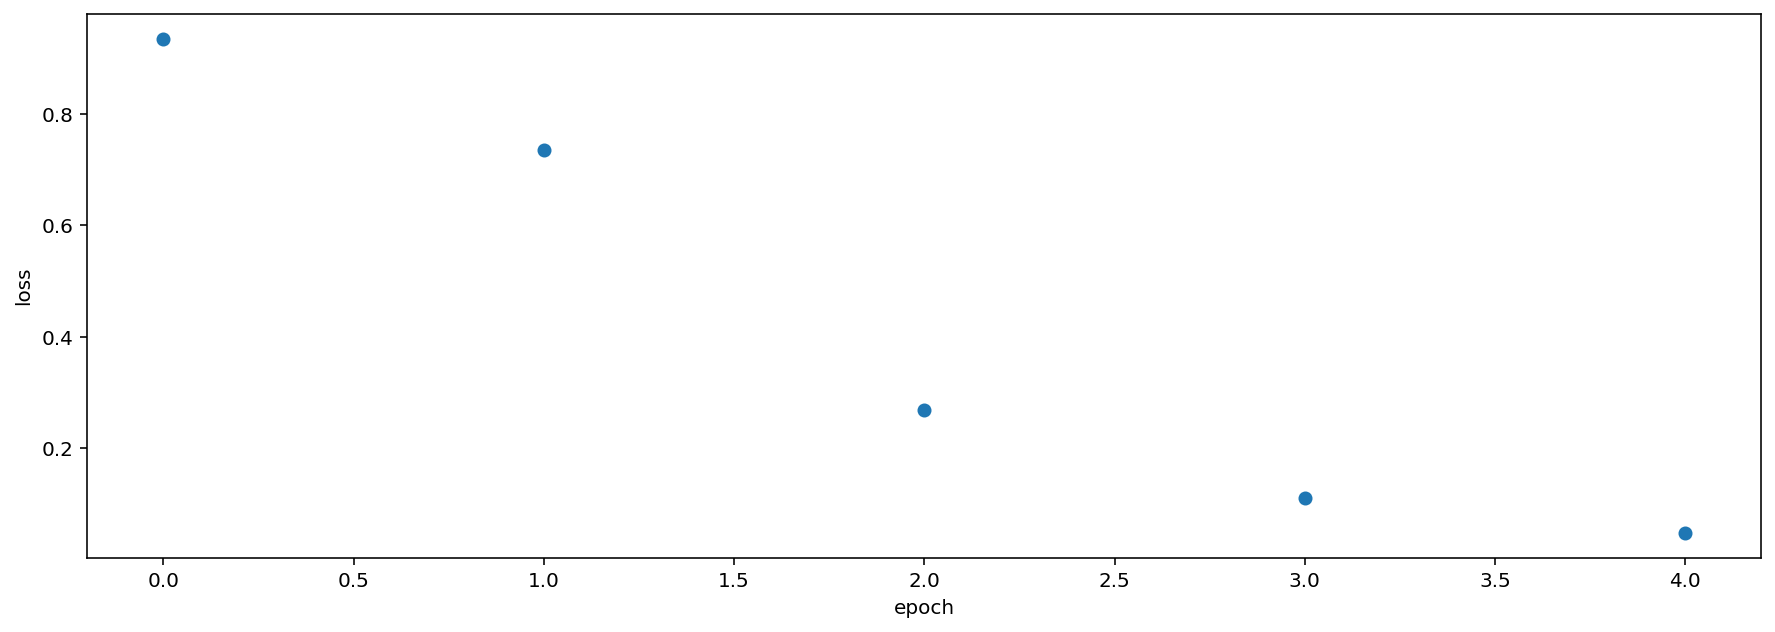

In [16]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

## Prediction
We haven't actually trained a useful model in 5 epochs, but we can use the trained model to demonstrate how prediction works and show several of the settings useful for prediction.

### Create preprocessor for prediction

Similar to training, prediction requires the use of a Preprocessor. To load audio and create a spectrogram without applying any augmentation, we use the class `AudioToSpectrogramPreprocessor`. We can use any Preprocessor class here as long as it provides the correct tensor shape to the model. 

In this instance, we'll reuse the validation dataset used above, but in a real application you would likely want to use the model for prediction on a separate dataset, such as a new and unlabeled dataset that you want to classify.

In [17]:
prediction_dataset = AudioToSpectrogramPreprocessor(valid_df)

### Predict on the validation dataset

We simply call model's `.predict()` method on a Preprocessor instance. 

This will return three dataframes:

- scores : numeric predictions from the model for each sample and class (by default these are raw outputs from the model)
- predictions: 0/1 predictions from the model for each sample and class (only generated if `binary_predictions` argument is supplied)
- labels: Original labels from the dataset, if available


In [18]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset)
valid_scores_df.head()

(6, 2)


,absent,present
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,-4.129051,5.384030
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,-1.180995,1.961839
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,-0.175372,0.853790
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,-3.567737,4.536744
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1.278766,-1.077118


In [19]:
# None: not generated because the `binary_predictions` argument was not supplied
valid_preds_df

In [20]:
valid_labels_df.head()

,absent,present
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0,1
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0,1
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0,1
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0,1
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1,0


The `valid_preds` dataframe in the example above is `None` - this is because we haven't specified an option for the `binary_preds` argument of predict. We can choose between `'single_target'` prediction (always predict the highest scoring class and no others) or `'multi_target'` (predict 1 for all classes exceeding a threshold).

### Binarize predictions

Supplying the `binary_preds` argument returns a dataframe in which the scores are "binarized," i.e., transformed from real numbers to either 0 or 1. 

**Note**: Binary predictions always have some error rates, sometimes large ones. It is not generally advisable to use these binary predictions as scientific observations without a thorough understanding of the model's false-positive and false-negative rates.

If you wish to output binary predictions, three options are available:

* `None`: default. do not create or return binary predictions
* `'single_target'`: predict that the highest-scoring class = 1, all others = 0
* `'multi_target'`: provide a `threshold`. Scores above threshold = 1, others = 0

For instance, using the option `'single_target'` chooses whichever of `'negative'` or `'positive'` is higher.

In [21]:
scores,preds,labels = model.predict(prediction_dataset,binary_preds='single_target')
preds.head()

(6, 2)


,absent,present
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0.0,1.0
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0.0,1.0
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0.0,1.0
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0.0,1.0
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1.0,0.0


The `'multi_target'` option allows you to select a threshold. If a score meets that threshold, the binary prediction is 1; otherwise, it is 0. 

Each score will have a function applied to it that takes the score from the real numbers, (-inf, inf), to the range [0, 1] (specifically the logistic sigmoid, or [expit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html) function). Whether the score meets this threshold will be based off of the sigmoid, not the raw score.

In [22]:
score_df, pred_df, label_df = model.predict(
    prediction_dataset,
    binary_preds='multi_target',
    threshold=0.1,
)
pred_df.head()

(6, 2)


,absent,present
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0.0,1.0
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,1.0,1.0
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,1.0,1.0
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0.0,1.0
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1.0,1.0


Note that in some of the above predictions, both the negative and positive classes are predicted to be present. This is because the `'multi_target'` option assumes that the classes are not mutually exclusive. For a presence/absence model like the one above, the `'single_target'` option is more appropriate.

### Change the activation layer
We can modify the final activation layer to change the scores returned by the `predict()` function. Note that this does not impact the results of the binary predictions (described above), which are always calcuated using a sigmoid transformation.

Options include:

* `None`: default. Just the raw outputs of the network, which are in (-inf, inf)
* `'softmax'`: scores across all classes will sum to 1 for each sample
* `'softmax_and_logit'`: softmax the scores across all classes so they sum to 1, then apply the "logit" transformation to these scores, taking them from [0,1] back to (-inf,inf)
* `'sigmoid'`: transforms each score individually to [0, 1] without requiring they sum to 1

In this case, since we are choosing between two mutually exclusive classes, we may want to use the `'softmax'` activation.

In [23]:
valid_scores, valid_preds, valid_labels = model.predict(prediction_dataset, activation_layer='softmax')

(6, 2)


Compare the softmax scores to the true labels for this dataset, side-by-side:

In [24]:
valid_scores.columns = ['pred_negative','pred_positive']
valid_dataset.df.join(valid_scores).sample(5)

,absent,present,pred_negative,pred_positive
filename,,,,
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0,1,0.000074,0.999926
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1,0,0.913401,0.086599
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0,1,0.263246,0.736754
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0,1,0.041375,0.958625
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0,1,0.000302,0.999698


### Parallelizing prediction

Two parameters can be used to increase prediction efficiency, depending on the computational resources available:

- `num_workers`: Pytorch's method of parallelizing across cores (CPUs) - choose 0 to predict on the root process, or >1 if you want to use more than 1 CPU
- `batch_size`: number of samples to predict on simultaneously

In [25]:
score_df, pred_df, label_df = model.predict(
    valid_dataset,
    batch_size=8,
    num_workers=0,
    binary_preds='multi_target'
)

(6, 2)


## Multi-class models
A multi-class model can have any number of classes, and can be either 

- multi-target: any number of classes can be positive for one sample
- single-target: exactly one class is positive for each sample

Training and prediction with these models looks similar to that of two-class models, with a few extra considerations.

For example, make a `Resnet18Multiclass` model. This model is multi-target by default, which you can see by inspecting the `model.single_target` attribute:

In [26]:
from opensoundscape.torch.models.cnn import Resnet18Multiclass
model = Resnet18Multiclass(classes)
print("model.single_target:", model.single_target)

created PytorchModel model object with 2 classes
model.single_target: False


If you want a single-target model, uncomment and run the following line.

In [27]:
#model.single_target = True

### Train
Training looks the same as in two-class models. In practice, using larger batch sizes (64+) improves stability and generalizability of training. 

In [28]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./multilabel_train/',
    epochs=1,
    batch_size=16,
    save_interval=100,
    num_workers=0
)

Epoch: 0 [batch 0/2 (0.00%)] 
	Jacc: 0.531 Hamm: 0.375 DistLoss: 19.650

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Saving weights, metrics, and train/valid scores.
Saving to multilabel_train/epoch-0.model
Updating best model
Saving to multilabel_train/best.model

Best Model Appears at Epoch 0 with F1 0.455.


### Predict
Prediction looks the same as demonstrated above, but make sure to think carefully:

* What `activation_layer` do I want? 
* If outputting binary predictions for each sample and class, is my model single-target (`binary_preds='single_target'`) or multi-target (`binary_preds='multi_target'`)?

For more detail on these choices, see the sections about activation layers and binary predictions above.

In [29]:
train_preds,_,_ = model.predict(train_dataset)
train_preds.columns = ['pred_negative','pred_positive']
train_dataset.df.join(train_preds).head()

(23, 2)


,absent,present,pred_negative,pred_positive
filename,,,,
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1,-4.783559,2.639524
./woodcock_labeled_data/ad90eefb6196ca83f9cf43b6f56c4b4a.wav,0,1,-3.593062,2.202178
./woodcock_labeled_data/e9e7153d11de3ac8fc3f7164d43bac92.wav,0,1,-3.737926,2.109899
./woodcock_labeled_data/c057a4486b25cd638850fc07399385b2.wav,0,1,-2.042692,1.099226
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1,-4.024426,2.497025


## Save and load models

A machine learning model is, in essence, a complex mathematical equation comprised of two parts:

* architecture: the particular structured connections between inputs and outputs of the model at various hierarchical stages, not modified during training. Examples of architectures in OpenSoundscape include `Resnet18Binary`.
* weights: the strength of these connections, tuned by training the model.

Training a model modifies the weights to attempt to better differentiate and classify samples. An analogy is linear regression: the "architecture" is a linear equation, and the "weights" are the slope and intercept identified to best fit the dataset.

Saving a model saves its weights. 

Loading a model applies the saved weights to an architecture. The architecture used to load the model must be identical to the architecture that was previously used to train the model and save the weights. Thus we will need to know the architecture to load the model.

### Save

OpenSoundscape saves models automatically during training:

* The model saves weights to `self.save_path` to `epoch-X.model` automatically during training every `save_interval` epochs
* The model keeps the file `best.model` updated with the weights that achieve the best F1 score on the validation dataset

You can also save the model manually at any time with `model.save(path)`.

In [ ]:
model1 = Resnet18Binary(classes)
# Save every 2 epochs
model1.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    epochs=6,
    batch_size=8,
    save_path='./binary_train/',
    save_interval=2,
    num_workers=0
)
model1.save('./binary_train/my_favorite.model')

created PytorchModel model object with 2 classes
Epoch: 0 [batch 0/3 (0.00%)] 
	Jacc: 0.524 Hamm: 0.250 DistLoss: 0.525

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Updating best model
Saving to binary_train/best.model
Epoch: 1 [batch 0/3 (0.00%)] 
	Jacc: 0.679 Hamm: 0.125 DistLoss: 0.297

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Saving weights, metrics, and train/valid scores.
Saving to binary_train/epoch-1.model
Epoch: 2 [batch 0/3 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.174

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Epoch: 3 [batch 0/3 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.052

Validation.
(6, 2)
	 Precision: 0.8333333333333334
	 Recall: 1.0
	 F1: 0.9090909090909091
Saving weights, metrics, and train/valid scores.
Saving to binary_train/epoch-3.model
Epoch: 4 [batch 0/3 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.008

Valid

### Load

Models can be loaded from a saved file by either of two methods:
- creating an instance of the model class, then calling `.load()`
- calling the model class's `.from_checkpoint()` method

In either case, you must know the architecture of the saved model (the OpenSoundscape class it was created with).

The two methods produce equivalent results:

In [ ]:
#create model object then load weights from checkpoint
model = Resnet18Binary(classes)
model.load('./binary_train/best.model')

In [ ]:
#or, create object directly from checkpoint
model = Resnet18Binary.from_checkpoint('./binary_train/best.model')

The model can now be used for prediction (`model.predict()`) or to continue training (`model.train()`).

## Predict using saved model

Using a saved or downloaded model to run predictions on audio files is as simple as

1. Creating a model object by loading previously saved weights
2. Creating an instance of a preprocessor class for prediction, e.g. `AudioToSpectrogramPreprocessor()`
3. Running `model.predict()` on the preprocessor

In [ ]:
# load the saved model
model = Resnet18Binary.from_checkpoint('./binary_train/best.model')

# create a Preprocessor instance with the audio samples
prediction_dataset = AudioToSpectrogramPreprocessor(valid_df,return_labels=False)

#predict on a dataset
scores,_,_ = model.predict(prediction_dataset, activation_layer='softmax_and_logit')

## Continue training from saved model

Similar to predicting using a saved model, we can also continue to train a model after loading it from a saved file. 

By default, `.load()` loads the optimizer parameters and learning rate parameters from the saved model, in addition to the network weights. 

In [ ]:
# Create architecture
model = Resnet18Binary(classes)

# Load the model weights and training parameters
model.load('./binary_train/best.model')

# Continue training from the checkpoint where the model was saved
model.train(train_dataset,valid_dataset,save_path='.',epochs=0)

## Next steps

You now have seen the basic usage of training CNNs with OpenSoundscape and generating predictions.  

Additional tutorials you might be interested in are:
* Custom preprocessing: how to change spectrogram parameters, modify augmentation routines, etc.
* Custom training: how to modify and customize model training
* Predict with pre-trained CNNs: details on how to predict with pre-trained CNNs. Much of this information was covered in the tutorial above, but this tutorial also includes information about using models made with previous versions of OpenSoundscape

Finally, clean up and remove files created during this tutorial:

In [ ]:
import shutil
dirs = ['./multilabel_train', './binary_train', './woodcock_labeled_data']
[shutil.rmtree(d) for d in dirs]